In [1]:
%connect_info

{
  "shell_port": 49756,
  "iopub_port": 49757,
  "stdin_port": 49758,
  "control_port": 49760,
  "hb_port": 49759,
  "ip": "127.0.0.1",
  "key": "a0de867a-dd6b520d1663ce29f1ed8d99",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-5dc57fc2-f961-4937-8b9e-994c5ab8aa33.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
import os, numpy as np, matplotlib.pyplot as plt, skimage, skimage.draw, scipy.io

In [3]:
data = np.zeros((100000, 26, 3), dtype=np.float32)

In [4]:
def renderPose(d):
    img = np.full((200, 200), 255, dtype=np.uint8)

    # Make sure the first axis is the joints (not the coordinates)
    if d.shape[0] < d.shape[1]:
        d = d.T

    for i in range(d.shape[0]):
        if not np.isnan(d[i,0]) and not np.isnan(d[i,1]):
            rr, cc = skimage.draw.circle(d[i,0], d[i,1], 3)
            img[np.clip(rr, 0, 199), np.clip(cc, 0, 199)] = 0
            
    # Plot limb lines
    def _plot(i, j):
        if not np.isnan(d[i,0]) and not np.isnan(d[i,1]) and \
                not np.isnan(d[j, 0]) and not np.isnan(d[j, 1]):
            rr, cc = skimage.draw.line(int(d[i,0]), int(d[i,1]), int(d[j,0]), int(d[j,1]))
            img[np.clip(rr, 0, 199), np.clip(cc, 0, 199)] = 128

    _plot(14,18); _plot(18,22)
    _plot( 2, 6); _plot( 6,10)

    _plot(15,19); _plot(19,23)
    _plot( 3, 7); _plot( 7,11)

    _plot(16,20); _plot(20,24)
    _plot( 4, 8); _plot( 8,12)

    _plot(17,21); _plot(21,25)
    _plot( 5, 9); _plot( 9,13)

    return img

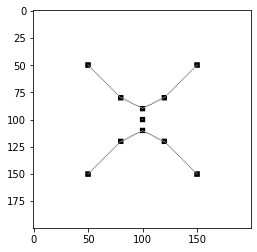

In [14]:
poseDefault = np.array([
    [ 10, 0, 0], # 0
    [-10, 0, 0], # 1
    [ 10, 0, 0], # 2
    [0, 0, 0], # 3
    [0, 0, 0], # 4
    [-10, 0, 0], # 5
    [20,20, 0], # 6
    [0, 0, 0], # 7
    [0, 0, 0], # 8
    [-20,20, 0], # 9
    [50,50, 0], # 10
    [0, 0, 0], # 11
    [0, 0, 0], # 12
    [-50,50, 0], # 13
    [10, 0, 0], # 14
    [0, 0, 0], # 15
    [0, 0, 0], # 16
    [-10, 0, 0], # 17
    [20,-20, 0], # 18
    [0, 0, 0], # 19
    [0, 0, 0], # 20
    [-20,-20, 0], # 21
    [50,-50, 0], # 22
    [0, 0, 0], # 23
    [0, 0, 0], # 24
    [-50,-50, 0]  # 25
], dtype=np.float32)

# Behavior 1
plt.imshow(renderPose(poseDefault + 100), cmap='gray')
plt.show()

In [15]:
FPS = 50

In [16]:
def getSineWave(freq, ampl, dur):
    return ampl * np.sin(freq * np.arange(dur) / (2 * np.pi) )

def getCosiWave(freq, ampl, dur):
    return ampl * np.cos(freq * np.arange(dur) / (2 * np.pi) )

In [17]:
# Randomly sample behaviors:
#     1. Uniformly sample behavioral state (0, 1, 2 or 3)
#     2. Uniformly sample duration (0.1 to 20 seconds)
#     3. Repeat until 600 seconds (30,000 frames) have been generated.
arrData = None

while arrData is None or arrData.shape[0] < 30000:
    # Sample state and duration (in #frames)
    state = np.random.randint(0,4)
    dur   = int( (np.random.random() * 19.9 + 0.1) * FPS )
    # Allocate behavioral array
    arrBehavior = np.repeat(poseDefault[np.newaxis,:,:], dur, axis=0)
    # Depending on behavioral state, modify this pose
    if state == 0:
        # State 0 is stationary
        pass
    elif state == 1:
        # State 1 is back legs (13 and 25) moving at 4 Hz
        arrBehavior[:,13,0] += getSineWave(4, 20, dur)
        arrBehavior[:,13,1] += getCosiWave(4, 20, dur)
        arrBehavior[:,25,0] += getSineWave(4, 20, dur)
        arrBehavior[:,25,1] += getCosiWave(4, 20, dur)
    elif state == 2:
        # State 2 is front legs (10 and 22) moving at 1 Hz
        arrBehavior[:,10,0] += getSineWave(1, 20, dur)
        arrBehavior[:,10,1] += getCosiWave(1, 20, dur)
        arrBehavior[:,22,0] += getSineWave(1, 20, dur)
        arrBehavior[:,22,1] += getCosiWave(1, 20, dur)
    elif state == 3:
        # State 3 is right legs (22 and 25) moving at 8 Hz
        arrBehavior[:,22,0] += getSineWave(8, 20, dur)
        arrBehavior[:,22,1] += getCosiWave(8, 20, dur)
        arrBehavior[:,25,0] += getSineWave(8, 20, dur)
        arrBehavior[:,25,1] += getCosiWave(8, 20, dur)
    # Add this block to the entire dataset
    arrData = arrBehavior if arrData is None else \
        np.vstack((arrData, arrBehavior))
    
# Save
dirOut = 'C:/Users/acorver/Desktop/testspider_1/'
os.makedirs(os.path.join(dirOut, 'croprot/'), exist_ok=True)
np.save(os.path.join(dirOut, 
    'croprot/testspider_1_dlc_abs_filt_interp_mvmt_noborder.npy'), 
    arrData + 100)

In [29]:
# Randomly sample behaviors:
#     1. Uniformly sample behavioral state (0, 1, 2 or 3)
#     2. Uniformly sample duration (0.1 to 20 seconds)
#     3. Repeat until 600 seconds (30,000 frames) have been generated.
arrData = None

while arrData is None or arrData.shape[0] < 30000:
    # Sample state and duration (in #frames)
    state = np.random.randint(0,4)
    dur   = int( (np.random.random() * 19.9 + 0.1) * FPS )
    # Allocate behavioral array
    arrBehavior = np.repeat(poseDefault[np.newaxis,:,:], dur, axis=0)
    # Depending on behavioral state, modify this pose
    if state == 0:
        # State 0 is stationary
        pass
    elif state == 1:
        # State 1 is back legs (13 and 25) moving at 4 Hz
        arrBehavior[:,13,0] += getSineWave(4, 20, dur)
        arrBehavior[:,13,1] += getCosiWave(4, 20, dur)
        arrBehavior[:,25,0] += getSineWave(4, 20, dur)
        arrBehavior[:,25,1] += getCosiWave(4, 20, dur)
    elif state == 2:
        # State 2 is front legs (10 and 22) moving at 1 Hz
        arrBehavior[:,10,0] += getSineWave(1, 20, dur)
        arrBehavior[:,10,1] += getCosiWave(1, 20, dur)
        arrBehavior[:,22,0] += getSineWave(1, 20, dur)
        arrBehavior[:,22,1] += getCosiWave(1, 20, dur)
    elif state == 3:
        # State 3 is right legs (22 and 25) moving at 8 Hz
        arrBehavior[:,22,0] += getSineWave(8, 20, dur)
        arrBehavior[:,22,1] += getCosiWave(8, 20, dur)
        arrBehavior[:,25,0] += getSineWave(8, 20, dur)
        arrBehavior[:,25,1] += getCosiWave(8, 20, dur)
    # Add this block to the entire dataset
    arrData = arrBehavior if arrData is None else \
        np.vstack((arrData, arrBehavior))
    
# Add gaussian noise to the data
arrData += np.random.normal(0, 5, size=arrData.shape)

# Save
dirOut = 'C:/Users/acorver/Desktop/testspider_2/'
os.makedirs(os.path.join(dirOut, 'croprot/'), exist_ok=True)
np.save(os.path.join(dirOut, 
    'croprot/testspider_2_dlc_abs_filt_interp_mvmt_noborder.npy'), 
    arrData + 100)

In [18]:
# Randomly sample behaviors:
#     1. Uniformly sample behavioral state (0, 1, 2 or 3)
#     2. Uniformly sample duration (0.1 to 20 seconds)
#     3. Repeat until 600 seconds (30,000 frames) have been generated.
arrData = None

prevState = -1
while arrData is None or arrData.shape[0] < 30000:
    # Sample state and duration (in #frames)
    state = np.random.randint(0 if prevState != 0 else 1,4)
    dur   = int( (np.random.random() * 1 + 0.5) * FPS ) \
        if state != 0 else \
            int( (np.random.random() * 10 + 10) * FPS )
    # Remember this state (to avoid repeatedly 
    # sampling low-modulation state)
    prevState = state
    # Allocate behavioral array
    arrBehavior = np.repeat(poseDefault[np.newaxis,:,:], dur, axis=0)
    # Depending on behavioral state, modify this pose
    if state == 0:
        # State 0 is a slow-modulated (low-frequency) behavior
        # (for 10-20 seconds)
        arrBehavior[:,13,0] += getSineWave(0.2, 20, dur)
        arrBehavior[:,13,1] += getCosiWave(0.2, 20, dur)
        arrBehavior[:,25,0] += getSineWave(0.2, 20, dur)
        arrBehavior[:,25,1] += getCosiWave(0.2, 20, dur)
        arrBehavior[:,10,0] += getSineWave(0.2, 20, dur)
        arrBehavior[:,10,1] += getCosiWave(0.2, 20, dur)
        arrBehavior[:,22,0] += getSineWave(0.2, 20, dur)
        arrBehavior[:,22,1] += getCosiWave(0.2, 20, dur)
    elif state == 1:
        # State 1 is back legs (13 and 25) moving at 4 Hz
        arrBehavior[:,13,0] += getSineWave(4, 20, dur)
        arrBehavior[:,13,1] += getCosiWave(4, 20, dur)
        arrBehavior[:,25,0] += getSineWave(4, 20, dur)
        arrBehavior[:,25,1] += getCosiWave(4, 20, dur)
    elif state == 2:
        # State 2 is front legs (10 and 22) moving at 1 Hz
        arrBehavior[:,10,0] += getSineWave(1, 20, dur)
        arrBehavior[:,10,1] += getCosiWave(1, 20, dur)
        arrBehavior[:,22,0] += getSineWave(1, 20, dur)
        arrBehavior[:,22,1] += getCosiWave(1, 20, dur)
    elif state == 3:
        # State 3 is right legs (22 and 25) moving at 8 Hz
        arrBehavior[:,22,0] += getSineWave(8, 20, dur)
        arrBehavior[:,22,1] += getCosiWave(8, 20, dur)
        arrBehavior[:,25,0] += getSineWave(8, 20, dur)
        arrBehavior[:,25,1] += getCosiWave(8, 20, dur)
    # Add this block to the entire dataset
    arrData = arrBehavior if arrData is None else \
        np.vstack((arrData, arrBehavior))
    
# Add gaussian noise to the data
#arrData += np.random.normal(0, 5, size=arrData.shape)

# Save
dirOut = '/Users/hsinyihung/Documents/PhD/JHU/Gordus lab/repositories/spider-side-behavior/pipeline/python/wavelet_analysis/notebook/'
os.makedirs(os.path.join(dirOut, 'croprot/'), exist_ok=True)
fname = os.path.join(dirOut, 'croprot/testspider_3_dlc_abs_filt_interp_mvmt_noborder.npy')
np.save(fname, arrData + 100)

In [19]:
settings = {
    'algorithm': 'dlc',
    # Include only front legs
    #'joints': [1, 6, 10, 18, 22, 9, 13, 21, 25],
    'joints': [10, 22, 13, 25],
    # Overwrite?
    'overwrite': True,
    # Use polar coordinates w.r.t. previous limb?
    'coords': 'euclidean',
    'include_absolute_position': 'no-abspos',
    'include_velocities': 'no-vel',
    'use_pca': 'no-pca',
    'numPeriods': 20,
    'fname_base': '/Users/hsinyihung/Documents/PhD/JHU/Gordus lab/repositories/spider-side-behavior/pipeline/python/wavelet_analysis/notebook/',
    'recordings': [
        '/Users/hsinyihung/Documents/PhD/JHU/Gordus lab/repositories/spider-side-behavior/pipeline/python/wavelet_analysis/notebook/',
    ],
    'n_iter': 500,
    'highpower_rows_per_file': 10000,
    'parallel': True,
    'metric': 'JS',
    'tsne_perplexities': [5, 50, 100, 500, 1000, 5000]
}
dirOut = '/Users/hsinyihung/Documents/PhD/JHU/Gordus lab/repositories/spider-side-behavior/pipeline/python/wavelet_analysis/notebook/'

In [10]:
import wavelet_sidecamera_fakespidersimulation

In [20]:
## Read simulation data
fname = 'testspider_3_dlc_abs_filt_interp_mvmt_noborder'

filename = '/Users/hsinyihung/Documents/PhD/JHU/Gordus lab/repositories/spider-side-behavior/pipeline/python/wavelet_analysis/notebook/aligned/croprot/'+fname +'.npy'

joint_data = np.load(filename)
joints = np.delete(joint_data, range(2, joint_data.shape[0], 3), axis=0)
joints = np.transpose(joints)


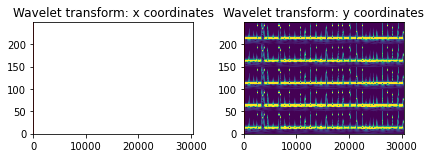

In [21]:
dirOut = '/Users/hsinyihung/Documents/PhD/JHU/Gordus lab/repositories/spider-side-behavior/pipeline/python/wavelet_analysis/notebook/aligned/'

joints = np.array(range(0,5))
wavelet_sidecamera_fakespidersimulation.Wavelet_transform(fname, filename, dirOut, joints)

In [2]:
import scipy.io, numpy as np, matplotlib.pyplot as plt

In [5]:
# Compare Matlab and Python outputs
fnameWavMatlab = 'C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.wavelet_output.mat'
arrWavMatlab = scipy.io.loadmat(fnameWavMatlab)['amplitudes']
np.save(fnameWavMatlab.replace('.wavelet_output.mat','') + '.wavelet_output.npy', arrWavMatlab)
arrFrqMatlab = scipy.io.loadmat(fnameWavMatlab)['f']
np.save(fnameWavMatlab.replace('.wavelet_output.mat','') + '.wavelet_output.freq.npy', arrFrqMatlab)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.wavelet_output.mat'

In [14]:
arrWavPython = np.load(fnameWavMatlab.replace('.wavelet_output.mat','.npy'))

In [15]:
arrWavPython.shape, arrWavMatlab.shape

((30177, 160), (30177, 160))

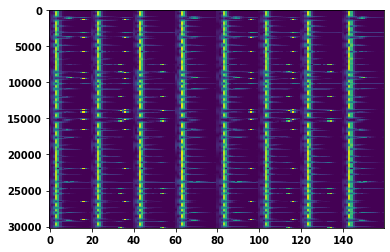

In [16]:
plt.imshow(arrWavPython, aspect='auto')

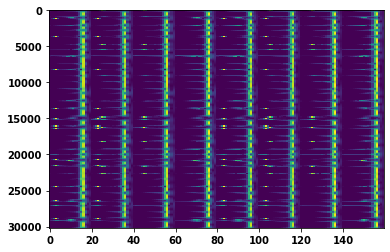

In [17]:
plt.imshow(arrWavMatlab, aspect='auto')

In [22]:
run_wavelet_cluster.runWaveletMerge(settings)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Processing: C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.npy
4c: C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.npy
2: C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.npy
3: C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.npy
5: C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.npy
1: C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.npy
6: C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.npy
7: C:/Users/acorver/Desktop/testspider_3/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.npy


In [23]:
run_wavelet_cluster.runWaveletHighPower(settings)

INFO:root:Keeping 10000 rows from file C:/Users/acorver/Desktop/testspider_3/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20.npy


In [24]:
run_wavelet_cluster.runClustering(settings)

INFO:root:Using file C:/Users/acorver/Desktop/testspider_3/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20/wavelet_dlc_euclidean_no-abspos_no-vel_00000000001001000000001001_20_hipow.npy


Starting shell....
C:\Users\acorver\.conda\envs\spider\python.exe C:\Users\acorver\Documents\repositories\spider-behavior\pipeline\python\behavioral_motifs\run_wavelet_cluster.py {\"command\": \"runDimensionalityReduction\", \"params\": {\"algorithm\": \"dlc\", \"joints\": \"00000000001001000000001001\", \"overwrite\": true, \"coords\": \"euclidean\", \"include_absolute_position\": \"no-abspos\", \"include_velocities\": \"no-vel\", \"use_pca\": \"no-pca\", \"numPeriods\": 20, \"fname_base\": \"C:/Users/acorver/Desktop/testspider_3/\", \"recordings\": [\"C:/Users/acorver/Desktop/testspider_3/\"], \"n_iter\": 500, \"highpower_rows_per_file\": 10000, \"parallel\": true, \"metric\": \"JS\", \"tsne_perplexities\": [5, 50, 100, 500, 1000, 5000], \"legvars\": {\"samplingFreq\": 50, \"omega0\": 5, \"numPeriods\": 20, \"maxF\": 25.0, \"minF\": 0.1, \"stack\": true, \"numProcessors\": 4}, \"thoraxvars\": {\"samplingFreq\": 50, \"omega0\": 5, \"numPeriods\": 20, \"maxF\": 1, \"minF\": 0.04, \"sta